### Bibliotecas:
Em princípio, é necessário importar as bibliotecas que serão usadas para criar as tabelas de pesquisa.

In [1]:
import numpy as np
import scipy.optimize as sci
import matplotlib.pyplot as plt
from scipy.optimize import root_scalar as root
import pandas as pd
from scipy.io import savemat

### Entrada de dados do usuário:
É necessário declarar os parâmetros associados à turbina eólica.

In [2]:
# Dados mecânicos
R = 37.5 # m
N = 111.5

# Constantes do coeficiente de potência
C = [0.22,116,0.4,0,0,5,12.5,0.08,0.035]

# Potência nominal
P_nom = 2 # MW

# Velocidade base:
W_base = 60*np.pi

# Densidade do ar 
par = 1.225 #kg/m³

# Dados de velocidade da turbina
Nmin_tur = 13 # rpm
Nnom_tur = 18 # rpm

# Dados da velocidade do vento 
Vw_min =  4 # m/s
Vw_nom = 12 # m/s
Vw_max = 25 # m/s

# Numero de passos por região
nstep = 200

### Levantando o coeficiente de potência máxima:
Para determinar as velocidades mínima e máxima da turbina, ou seja, as referências das regiões 1 e 3, é necessário encontrar o valor ótimo do coeficiente de potência.

\begin{gather}
	C_p(\lambda, \beta) = C_1 \left(\frac{C_2}{\alpha(\lambda, \beta)} - C_3\,\beta - C_4\,\beta ^{C_5} - C_6 \right) e^{-\frac{C_7}{\alpha(\lambda, \beta)}}
	\label{eq:G3_powerCoef1}
\end{gather}

\begin{gather}
	\frac{1}{\alpha(\lambda, \beta)} =  \frac{1}{\lambda - C_8\, \beta} - \frac{C_9}{\beta^3 + 1}
	\label{eq:G3_powerCoef2}
\end{gather}

In [3]:
# Função para o coeficiente de potência: 
def CP(x):
  alpha = (1 / (x[0]+ x[1] * C[7]) - C[8] / (x[1] ** 3 + 1))**-1
  cp = C[0] * (C[1] / alpha - C[2] * x[1] - C[3] * x[1] ** C[4] - C[5]) * np.exp(-C[6] / alpha)
  return -cp

# Realizando a otimização
opt = sci.minimize(CP,[1,0], bounds = [[0, 30],[0, 30]])

LBD_opt = opt.x[0]  # Lambda ótimo
Beta_opt = opt.x[1] # Beta ótimo
CP_opt = -opt.fun   # CP ótimo

print(f'Convergiu -> {opt.success}')
print(f'Coeficiente de potência máximo -> {-opt.fun}')
print(f'Lambda ótimo -> {opt.x[0]}')
print(f'Beta ótimo -> {opt.x[1]}')

Convergiu -> True
Coeficiente de potência máximo -> 0.4382090105978689
Lambda ótimo -> 6.324969981694354
Beta ótimo -> 0.0


### Região 1 e 3: Seguindo a velocidade mínima e nominal
Para a investigação da região 1, é necessário definir a referência de velocidade mínima juntamente com a velocidade do vento que resulta nesta velocidade mínima.

\begin{align}
    V_w^{\omega_{min}} = n_{tur}^{min} \left(\frac{2\,\pi}{60}\right)\,\frac{R}{\lambda_{opt}}
\end{align}

Para a investigação da região 3, é necessário definir a referência de velocidade nominal juntamente com a velocidade do vento que resulta nesta velocidade nominal.

\begin{align}
    V_w^{\omega_{nom}} = n_{tur}^{nom} \left(\frac{2\,\pi}{60}\right)\,\frac{R}{\lambda_{opt}}
\end{align}

A premissa para o ângulo de passo é permanecer inativo durante esta região.

In [4]:
# Region 1 - Velocidade mínima
Wmin_br = Nmin_tur*(2*np.pi/60)
Vw_wmin = Wmin_br*(R/LBD_opt)

Wmin = Wmin_br*N
print(f'Velocidade mínima de referência -> {Wmin} rad/s')
print(f'Velocidade terminal de referência para a região 1 -> {Vw_wmin} m/s')

# Region 3 - Velocidade nominal
Wnom_br = Nnom_tur*(2*np.pi/60)
Vw_wnom = Wnom_br*(R/LBD_opt)

Wnom = Wnom_br*N
print(f'Velocidade nominal de referência -> {Wnom} rad/s')
print(f'Velocidade terminal de referência para a região 3 -> {Vw_wnom} m/s')

Velocidade mínima de referência -> 151.79128504594684 rad/s
Velocidade terminal de referência para a região 1 -> 8.071323779968116 m/s
Velocidade nominal de referência -> 210.17254852515717 rad/s
Velocidade terminal de referência para a região 3 -> 11.175679079955854 m/s


### Região 2: Rastreamento do ponto de máxima potência
A premissa da presente região baseia-se em calcular o valor associado ao ângulo de passo e à velocidade específica da turbina para que isso resulte no coeficiente de potência máxima para qualquer velocidade do vento dada.

In [5]:
# Region 2 - Maximização do coeficiente de potência.
def F(Vw):
  def f(myVetf):
    alpha = (1 / ((R*myVetf[0]/Vw/N) + myVetf[1] * C[7]) - C[8] / (myVetf[1] ** 3 + 1))**-1
    Cp = C[0] * (C[1] / alpha - C[2] * myVetf[1] - C[3] * myVetf[1] ** C[4] - C[5]) * np.exp(-C[6] / alpha)
    return -Cp
  return f

# Declaração dos vetores
Vw_vet = np.linspace(Vw_wmin,Vw_wnom,nstep)
Wrm_vetR2 = np.zeros_like(Vw_vet)
beta_vetR2 = np.zeros_like(Vw_vet)
v0 = [100, 1]

# Chamando solver
for k,v in enumerate(Vw_vet):
  sol = sci.minimize(F(v), v0, bounds = [[100, 300],[0, 30]]) 
  Wrm_vetR2[k] = sol.x[0]
  beta_vetR2[k] = sol.x[1]

### Região 4: Limitando a potência da turbina
Para investigar a região 4, é necessário definir os valores para o ângulo de passo para que a potência não exceda a nominal definida para a turbina eólica, sob velocidade nominal constante.

In [6]:
# Função para o coeficiente de potência:
def Ptur(Vw, Wtur, beta):
  LBD = R * Wtur/Vw
  Ptur = 1 / 2 * par * np.pi*R**2 *-CP([LBD, beta])* Vw **3
  return Ptur

# Função objetivo
def F(Vw):
  def f(beta):
    Ptur_nom = Ptur(Vw_nom, Wnom_br, 0)
    return Ptur_nom - Ptur(Vw,Wnom_br,beta)
  return f

# Declarando vetores
Vw_vet = np.linspace(Vw_nom,Vw_max,nstep)
beta_vet = np.zeros_like(Vw_vet)
v0 = 0

# Chamando solver
for k,v in enumerate(Vw_vet):
  sol = root(F(v), bracket=(0,35), method='bisect')
  beta_vet[k] = sol.root
  v0 = beta_vet[k]

### Criando uma tabela de visualização:
A tabela de pesquisa será criada nesta seção e relaciona os valores de referência para a velocidade e ângulo de passo com as velocidades do vento às quais a presente turbina eólica pode estar sujeita.

In [7]:
vetor_Wrm = np.zeros(int(4*nstep))
vetor_Bet = np.zeros(int(4*nstep))

Wrm_R1 = Wmin*np.ones(int(nstep))
Wrm_R2 = Wrm_vetR2
Wrm_R3 = Wnom*np.ones(int(nstep))
Wrm_R4 = Wrm_R3
vetor_Wrm = np.concatenate((Wrm_R1,Wrm_R2,Wrm_R3,Wrm_R4))

Bet_R1 = np.zeros(int(nstep))
Bet_R2 = beta_vetR2
Bet_R3 = np.zeros(int(nstep))
Bet_R4 = beta_vet
vetor_Bet = np.concatenate((Bet_R1,Bet_R2,Bet_R3,Bet_R4))

Vw_R1 = np.linspace(Vw_min, Vw_wmin, int(nstep))
Vw_R2 = np.linspace(Vw_wmin+1e-3, Vw_wnom, int(nstep))
Vw_R3 = np.linspace(Vw_wnom+1e-3, Vw_nom, int(nstep))
Vw_R4 = np.linspace(Vw_nom +1e-3, Vw_max, int(nstep))
vetor_Vw = np.concatenate((Vw_R1,Vw_R2,Vw_R3,Vw_R4))

lTable = pd.DataFrame({'Vw': vetor_Vw,
                       'Wrm': vetor_Wrm,
                       'Beta': vetor_Bet})

# lTable
# print(lTable.to_latex(index=False))  

### Criando o vetor de potência da turbina:
Para a caracterização aerodinâmica da potência de entrada do sistema será utilizada a expressão abaixo, amplamente empregada na literatura, que representa a potência disponível em uma massa de ar ($P_w$), assumindo a velocidade do vento uniforme sobre as pás da turbina.

\begin{gather}
	P_{w} = \frac{1}{2}\,\rho_{ar}\, A\,  {V_w}^3
\end{gather}

Entretanto, em uma turbina eólica apenas uma parcela da energia disponível na massa de ar é absorvida, devido a característica não ideal de sua aerodinâmica que pode ser representada através de uma função $C_p(\lambda, \beta)$. Sendo assim, a potência entregue ao eixo ($P_{tur}$) pode ser expressa como uma quantidade percentual da potência disponível na massa de ar que passa pela turbina.

\begin{gather}
	P_{tur} =  P_{w} \, C_p(\lambda, \beta)
\end{gather}

In [8]:
def CP(LBD, BETA): # Função para o coeficiente de potência:
  alpha = (1 / (LBD+ BETA * C[7]) - C[8] / (BETA ** 3 + 1))**-1
  cp = C[0] * (C[1] / alpha - C[2] * BETA - C[3] * BETA ** C[4] - C[5]) * np.exp(-C[6] / alpha)
  return cp

vetor_Pot = np.zeros_like(vetor_Vw)
vetor_Cp = np.zeros_like(vetor_Vw)
A = np.pi*R**2

for k,v in enumerate(vetor_Vw):
    vetor_Cp[k] = CP(vetor_Wrm[k]*R/v/N, vetor_Bet[k])
    vetor_Pot[k] = (vetor_Cp[k])*0.5*par*A*v**3

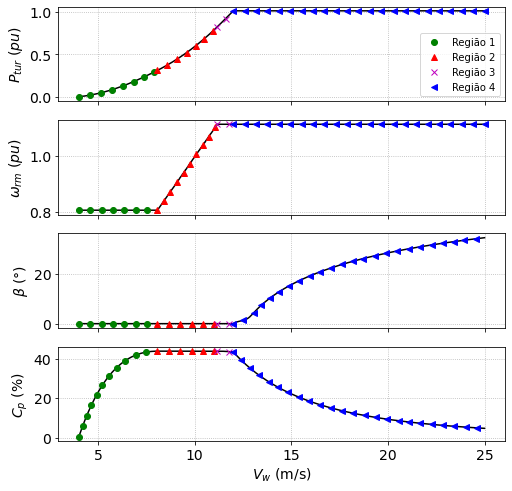

In [9]:
# Declaração da Figura:
fig, [ax1, ax2, ax3, ax4] = plt.subplots(4, 1, sharex=True)
fig.set_size_inches(8, 8)

# Plots:
ax1.plot(vetor_Vw, vetor_Pot/(P_nom*1e6), color='0')
ax1.plot(vetor_Vw[:200], vetor_Pot[:200]/(P_nom*1e6), 'go', markevery=0.025, label="Região 1")
ax1.plot(vetor_Vw[200:400], vetor_Pot[200:400]/(P_nom*1e6), 'r^', markevery=0.025, label="Região 2")
ax1.plot(vetor_Vw[400:600], vetor_Pot[400:600]/(P_nom*1e6), 'mx', markevery=0.025, label="Região 3")
ax1.plot(vetor_Vw[600:], vetor_Pot[600:]/(P_nom*1e6), 'b<', markevery=0.025, label="Região 4")

ax2.plot(vetor_Vw, vetor_Wrm/W_base, color='0')
ax2.plot(vetor_Vw[:200], vetor_Wrm[:200]/W_base, 'go', markevery=0.025)
ax2.plot(vetor_Vw[200:400], vetor_Wrm[200:400]/W_base, 'r^', markevery=0.025)
ax2.plot(vetor_Vw[400:600], vetor_Wrm[400:600]/W_base, 'mx', markevery=0.025)
ax2.plot(vetor_Vw[600:], vetor_Wrm[600:]/W_base, 'b<', markevery=0.025)

ax3.plot(vetor_Vw, vetor_Bet, color='0')
ax3.plot(vetor_Vw[:200], vetor_Bet[:200], 'go', markevery=0.025)
ax3.plot(vetor_Vw[200:400], vetor_Bet[200:400], 'r^', markevery=0.025)
ax3.plot(vetor_Vw[400:600], vetor_Bet[400:600], 'mx', markevery=0.025)
ax3.plot(vetor_Vw[600:], vetor_Bet[600:], 'b<', markevery=0.025)

ax4.plot(vetor_Vw, vetor_Cp*100, color='0')
ax4.plot(vetor_Vw[:200], vetor_Cp[:200]*100, 'go', markevery=0.025)
ax4.plot(vetor_Vw[200:400], vetor_Cp[200:400]*100, 'r^', markevery=0.025)
ax4.plot(vetor_Vw[400:600], vetor_Cp[400:600]*100, 'mx', markevery=0.025)
ax4.plot(vetor_Vw[600:], vetor_Cp[600:]*100, 'b<', markevery=0.025)

ax1.set_xlabel("", fontsize=14)
ax1.set_ylabel("$P_{tur}$ $(pu)$", fontsize=14)

ax2.set_xlabel("", fontsize=14)
ax2.set_ylabel("$\omega_{rm}$ $(pu)$", fontsize=14)

ax3.set_xlabel("", fontsize=14)
ax3.set_ylabel("$\\beta$ $(°)$", fontsize=14)

ax4.set_xlabel("$V_w$ (m/s)", fontsize=14)
ax4.set_ylabel("$C_p$ (%)", fontsize=14)

ax1.grid(True, linestyle='dotted')
ax2.grid(True, linestyle='dotted')
ax3.grid(True, linestyle='dotted')
ax4.grid(True, linestyle='dotted')

ax1.tick_params(axis='x', labelsize=14) 
ax1.tick_params(axis='y', labelsize=14)

ax2.tick_params(axis='x', labelsize=14) 
ax2.tick_params(axis='y', labelsize=14) 

ax3.tick_params(axis='x', labelsize=14) 
ax3.tick_params(axis='y', labelsize=14) 

ax4.tick_params(axis='x', labelsize=14) 
ax4.tick_params(axis='y', labelsize=14) 

ax1.grid(True, linestyle='dotted')
ax2.grid(True, linestyle='dotted')
ax3.grid(True, linestyle='dotted')
ax4.grid(True, linestyle='dotted')

ax1.legend(loc='lower right')

plt.show()
fig.savefig("produtoLT.pdf", bbox_inches='tight', pad_inches=0)

In [10]:
# Exportando as Lookup tables:
mybetaR4 = np.array([(Vw_R4-Vw_R4[0]).tolist(), Bet_R4.tolist()]).T
savemat('LookupTables/betaR4.mat', {'beta':mybetaR4})

Wrmb = 60*np.pi
myWrmR2 = np.array([(Vw_R2-Vw_R2[0]).tolist(), (Wrm_R2/Wrmb).tolist()]).T
savemat('LookupTables/omegaR2.mat', {'omega':myWrmR2})